In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt
from scipy import linalg

In [2]:
from scipy import optimize

In [5]:
import pchem.calorimetry as cal

ModuleNotFoundError: No module named 'pchem.calorimetry'

In [4]:
H2O = cal.Substance2("H2O(l)", state='l', H0=-285.826e3, S0=69.96,
                        cP=4.18*18.02, molarMass=18.02, density=1.0,
                        atoms=dict(H=2,O=1, c=0))
Hplus = cal.Substance2("H+(aq)", state="aq", H0=0, S0=0, cP=0,
                       molarMass=1.01, density=0,
                      atoms=dict(H=1,c=1))
OH = cal.Substance2("OH-(aq)", state="aq", H0=-230.02e3, S0=-10.9, molarMass=17.01,
                   cP=-148.5, density=0, atoms=dict(H=1,O=1,c=-1))

HF = cal.Substance2('HF(aq)', state="aq", H0=-324.93e3, S0=-13.8, molarMass=18.998+1.01,cP=0,
                    density=0, atoms=dict(H=1,F=1))
F = cal.Substance2('F-(aq)', state="aq", H0=-335.35e3, S0=-13.8, molarMass=18.998,cP=-106.7,
                   density=0, atoms=dict(F=1,c=-1))


dH_ice = -6.01e3
T_ice  = 273.15

ice = cal.phaseChange(dH_ice, T_ice, H2O, cP=2.108*H2O.molarMass,
                    name="ice", state='s', density=0.91, atoms=dict(H=2,O=1))


chemicals = {0: H2O, 
#              1:Hplus, 2: OH, 
             3: ice, 
#              4: HF, 5:F
            }

rxns = [{0: -1, 1: 1, 2: 1}]

s0 = cal.State3(T=268.15, chemicals=chemicals, rxns=[], V=None)

n0 = 1000/18.02

s0.set_state({0: 0.0,  3: n0})
x0 = s0.x

NameError: name 'cal' is not defined

In [408]:
[x.name for x in s0.chem_vals]

['H2O(l)', 'ice']

In [445]:
def scale(x, v):
    return v*np.where(
        (x>0.0) | (v<=0), 1.0, 0.0)
        

def scale_d(x, v):
        return v*np.where( (x==0), 1, 0)

def f2(x0, s, dH):
    mu = s.mu(x0)
    Gbar = s.get_prop_conc('Gbar', x=x0[:-1], T=x0[-1])
    resid = Gbar - s.A.T@mu # Chemical potential substance - chemical potential atom
    d_moles = s.A @ x0[:-1] - s.n_moles
    H0 = s.get_prop_conc('Hbar') @ s.x
    H1 = s.get_prop_conc('Hbar', x=x0[:-1], T=x0[-1])
    
    Sbar = s.get_prop_conc('Sbar', x=x0[:-1], T=x0[-1])
    
    cP_total = s.get_prop('cP') @ x0[:-1]
    
    V = s.volume(x0[:-1])


    
    T = x0[-1]
    R = 8.3145
    
    jac = np.diag(R*T/x0[:s.N_aq] *scale(V*np.ones(s.N_aq), resid[:s.N_aq]) + 
            scale_d(x0[:s.N_aq], resid[:s.N_aq])) # Diagonal on top...
    
    J = np.zeros(shape=(s.N_chem+s.N_atoms+1, s.N_chem+1))
    
    J[:s.N_aq, :s.N_aq] = jac
    
    for i in range(s.N_aq, s.N_chem):
        J[i, i] = scale_d(x0[i], resid[i])
        
    
    J[:s.N_chem, -1] = -Sbar
    
    J[s.N_chem:-1, :-1] = -s.A
    
    J[-1, :-1] = H1
    J[-1, -1] = cP_total
    
    return np.r_[scale(x0[:-1], resid), d_moles, (H1@x0[:-1] - H0) - dH]


In [453]:
def Jac(x0, s, dH):
    mu = s.mu(x0)
    Gbar = s.get_prop_conc('Gbar', x=x0[:-1], T=x0[-1])
    resid = Gbar - s.A.T@mu # Chemical potential substance - chemical potential atom
    d_moles = s.A @ x0[:-1] - s.n_moles
    H0 = s.get_prop_conc('Hbar') @ s.x
    H1 = s.get_prop_conc('Hbar', x=x0[:-1], T=x0[-1])
    
    Sbar = s.get_prop_conc('Sbar', x=x0[:-1], T=x0[-1])
    
    cP_total = s.get_prop('cP') @ x0[:-1]
    
    V = s.volume(x0[:-1])


    
    T = x0[-1]
    R = 8.3145
    
    jac = np.diag(R*T/x0[:s.N_aq] *scale(V*np.ones(s.N_aq), resid[:s.N_aq]) + 
            scale_d(x0[:s.N_aq], resid[:s.N_aq])) # Diagonal on top...
    
    J = np.zeros(shape=(s.N_chem+s.N_atoms+1, s.N_chem+1))
    
    J[:s.N_aq, :s.N_aq] = jac
    
    for i in range(s.N_aq, s.N_chem):
        J[i, i] = scale_d(x0[i], resid[i])
        
    
    J[:s.N_chem, -1] = -Sbar
    
    J[s.N_chem:-1, :-1] = -s.A
    
    J[-1, :-1] = H1
    J[-1, -1] = cP_total
    
    return J

In [454]:
df = f2(np.array([0, n0, 268.15]), s0, 100.0)

268.15


In [455]:
# optimize.leastsq(f2, np.array([0, n0, 268.15]), args=(s0,100.0), Dfun=Jac)

268.15
268.15
268.15
268.15
268.15
268.15000001904707
268.1627288311394
268.15388657708655
268.1506408871565


/Users/dwyerry/miniconda3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:745: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.weights)[:, None] * x
/Users/dwyerry/miniconda3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:743: RuntimeWarning: invalid value encountered in sqrt
  return x * np.sqrt(self.weights)


(array([  0.        ,  55.49389567, 268.15      ]), 2)

In [432]:
linalg.lstsq(Jac, -df)

(array([ 1.37739845e-08, -3.40254708e-04,  1.90470769e-08]),
 5.788201612665907e-07,
 3,
 array([4.11558425e+05, 1.02389014e+02, 3.07106885e+01]))

In [416]:
f2(s0, np.r_[np.array([0, n0]), s0.T], 100.0)

268.15


(array([ 0.00000000e+00, -5.82076609e-11,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00, -1.00000000e+02]),
 array([[ 1.08293640e+02,  0.00000000e+00, -6.19719179e+01],
        [ 0.00000000e+00, -0.00000000e+00, -4.06591483e+01],
        [-2.00000000e+00, -2.00000000e+00,  0.00000000e+00],
        [-1.00000000e+00, -1.00000000e+00,  0.00000000e+00],
        [-0.00000000e+00, -0.00000000e+00,  0.00000000e+00],
        [-2.88085708e+05, -2.93909021e+05,  2.10800000e+03]]))

In [403]:
y_eq = s0.A.T @ mu # Chemical potential...

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 3 is different from 4)

In [209]:
y = s0.get_prop_conc('Gbar')

In [210]:
y - y_eq

array([ 1.08293640e+02, -5.82076609e-11])

In [211]:
out = s0.mu()
mu0 = out.params
mu0

268.15


AttributeError: 'numpy.ndarray' object has no attribute 'params'

AttributeError: 'numpy.ndarray' object has no attribute 'params'

In [196]:
s0.all_atoms

('H', 'O', 'c')

In [197]:
[x.name for x in s0.chem_vals]

['H2O(l)', 'ice']

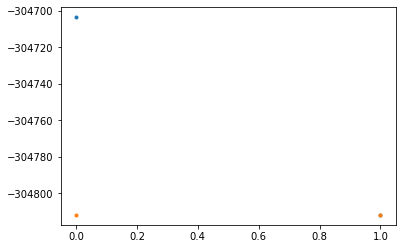

In [200]:
plt.plot(y, '.')
plt.plot(s0.A.T@mu, '.')

In [199]:
AtA = (s0.A @ s0.A.T)

In [179]:
import statsmodels.api as sm

In [111]:
out = sm.WLS(y, s0.A.T, weights=x0+1e-3).fit().params

In [112]:
s0.A.T@out

array([-304811.76947343, -304811.76947343])

In [137]:
mu

array([-120369.06729753,  -60184.53364877,       0.        ])

In [136]:
out

array([-120369.06729753,  -60184.53364877,       0.        ])

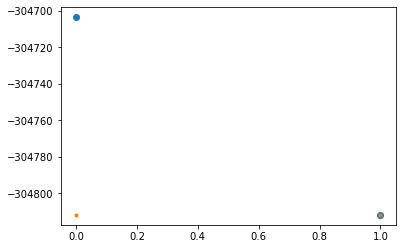

In [113]:
plt.plot(y, 'o')
plt.plot(s0.A.T@out, '.')

In [144]:
v1 = s0.A.T@out

In [145]:
v1

array([-300922.66824383, -300922.66824383])

In [146]:
y

array([-304703.47778434, -304811.77142481])

In [57]:
s0.A.T @ mu0

array([-300922.66760443, -300922.66760443])

In [172]:
for i in range(10):
    out = s0._solve_no_rxns(500.0)
    s0.x = out[1]
    s0.T = out[2]
    print(out[1]-x0)
    print(out[2])

(3, 5)
[ 0.00100418  0.00100418  0.19869654 -0.19970072]
267.80463640959897
(3, 5)


/Users/dwyerry/programming/pchem/pchem/calorimetry.py:513: RuntimeWarning: divide by zero encountered in double_scalars
  concs.append(mol/V)


[ 1.1210687e-02  1.1210687e-02  9.5323358e-13 -1.1210687e-02]
268.258739052737
(3, 5)
[ 1.58691965e-02  1.58691965e-02  1.43067341e-16 -1.58691965e-02]
268.34506194728243
(3, 5)
[ 1.58691965e-02  1.58691965e-02  5.77595778e-16 -1.58691965e-02]
268.5825870556159
(3, 5)
[ 6.55224661e-03  6.55224661e-03  2.20383163e-08 -6.55226864e-03]
269.1220509540285
(3, 5)
[ 8.29907232e-03  8.29907232e-03  5.22023740e-16 -8.29907232e-03]
269.3028913572438
(3, 5)
[ 2.68481189e-19  1.62205753e-18  1.27985061e-14 -1.42108547e-14]
269.8084868724161
(3, 5)
[ 2.39216740e-19  1.44525326e-18  1.14034689e-14 -1.42108547e-14]
269.8084868724162
(3, 5)
[ 2.39216740e-19  1.44525326e-18  1.14034689e-14 -1.42108547e-14]
269.8084868724162
(3, 5)
[ 2.39216740e-19  1.44525326e-18  1.14034689e-14 -1.42108547e-14]
269.8084868724162


In [173]:
Positive directional derivative for linesearch

SyntaxError: invalid syntax (1051061727.py, line 1)

In [174]:
out

(     fun: -2269.3321979572224
      jac: array([-56.17097547, -45.14875597, -62.43635373, -40.89336621,
         -7.81294919])
  message: 'Positive directional derivative for linesearch'
     nfev: 1
      nit: 5
     njev: 1
   status: 8
  success: False
        x: array([2.39216740e-19, 1.44525326e-18, 1.14034689e-14, 5.54938957e+01,
        0.00000000e+00]),
 array([2.39216740e-19, 1.44525326e-18, 1.14034689e-14, 5.54938957e+01]),
 269.8084868724162)

In [175]:
dH = 100.9
self = s0
A = self.A
b = self.x # Current state...
Ag = np.c_[A, np.zeros(self.N_atoms)] # Add zeros for temp?
T0 = self.T

Hbar0 = self.get_prop_conc('Hbar', x=b, T=T0)

cP = self.get_prop('cP')

def HconstaintFunc(x):
    T = T0 + x[-1]
    Hbar = self.get_prop_conc('Hbar', x=x[:-1], T=T)
    
    return np.dot(Hbar, x[:-1]) - Hbar0

def HconstaintFunc_jac(x):
    T = T0 + x[-1]
    Hbar = self.get_prop_conc('Hbar', x=x[:-1], T=T)
    return np.r_[Hbar, cP@x[:-1]].reshape(1, -1)

Hconstraint = optimize.NonlinearConstraint(HconstaintFunc, lb=np.array([dH]), ub=np.array([dH]), jac=HconstaintFunc_jac)
bounds = optimize.LinearConstraint(Ag, lb=self.n_moles, ub=self.n_moles) # Reaction constraint...

In [176]:
HconstaintFunc(np.r_[s0.x, 0.0])

array([-16306660.44685386, -16080849.1615533 , -16018699.66205564,
       -16012814.42560155])

In [177]:
np.dot(Hbar0, x[:-1])

TypeError: 'Symbol' object is not subscriptable

In [178]:
s0.A @ s0.x

array([ 1.10987791e+02,  5.54938957e+01, -1.20603652e-18])

The other approach was,

$$ \max S $$

subject to the constraints,

$$ H_\text{total} = h \cdot n $$

where $n$ is the vector of moles of each substance, and

$$ b = A n$$

Do I need the Lagrangian multipliers here? Probably not?


In [179]:
s0.fH()

array([2.39216740e-19, 1.44525326e-18, 1.14034689e-14, 5.54938957e+01])

In [180]:
s0._solve_iterative()

(array([ 5.17249482e+13,  4.22456093e+29, -8.60117924e+02, -8.04623976e+02,
        -3.15909301e-16, -1.57954650e-16, -2.36658272e-30]),
 [51.993770740127474,
  104.39834425955777,
  104.39834582369414,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0274235757415902,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0720411540826085,
  1.052671327905923,
  1.0,
  1.0,
  1.100196885277871,
  1.0,
  1.048458315428924,
  1.0984944257361562,
  1.0984042469036712,
  1.0,
  1.043818725762657,
  1.0,
  1.0,
  1.0620263962905252,
  1.1236625497097403,
  1.1437093673245808,
  1.0,
  1.171150643498578,
  1.0081108805499728,
  1.000000000000007,
  1.0,
  1.0,
  1.0,
  1.1108208395064096,
  3.2603837595358556,
  1.3922030966905545,
  1.5461355464415805,
  852.7121094880165,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  0.9999999999999858,


In [16]:
s0.fi(np.array([1.0, 0.01, 0.01, 0,0,0]))

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 2 is different from 3)

In [17]:
s0.fi

<bound method State3.fi of State3(T=269.8084868724162, chemicals={0: Substance2(name='H2O(l)', H0=-285826.0, S0=69.96, cP=75.3236, molarMass=18.02, state='l', density=1.0, atoms={'H': 2, 'O': 1, 'c': 0}, T0=298.15, conc0=1), 1: Substance2(name='H+(aq)', H0=0, S0=0, cP=0, molarMass=1.01, state='aq', density=0, atoms={'H': 1, 'c': 1}, T0=298.15, conc0=1), 2: Substance2(name='OH-(aq)', H0=-230020.0, S0=-10.9, cP=-148.5, molarMass=17.01, state='aq', density=0, atoms={'H': 1, 'O': 1, 'c': -1}, T0=298.15, conc0=1), 3: Substance2(name='ice', H0=-293719.09, S0=41.36092628008828, cP=37.98616, molarMass=18.02, state='s', density=0.91, atoms={'H': 2, 'O': 1}, T0=273.15, conc0=1)}, rxns=[], V=None, x=array([2.39216740e-19, 1.44525326e-18, 1.14034689e-14, 5.54938957e+01]), x_keys=array([1, 2, 0, 3]))>

In [18]:
def f2(x):
    RT = 8.3145*298.15
    V=1
    return np.array([np.log(x[0]/V)-x[2]*2, np.log(x[1]/V)+5000/RT-x[2], 2-x[0]*2-x[1]])

In [19]:
xf2 = np.array([0.99, 0.02, 0])
f2(xf2)

array([-1.00503359e-02, -1.89505480e+00,  1.73472348e-17])

In [20]:
A2 = np.array([[2, 1]])

In [21]:
def f2it(x):
    RT = 8.3145*298.15
    V=1
    A = np.array([[1, 0, -2], [0, 1, -1], [2*x[0], x[1], 0]])
    b = np.array([-np.log(x[0]/V), -np.log(x[1]/V)-3000/RT, 2-x[0]*2-x[1]])
    return linalg.solve(A, b)

In [22]:
out = f2it(xf2)
val = np.log(xf2[:2]) + out[:2]
xf3 = np.r_[np.exp(val), out[2:]]

In [23]:
f2(xf3)

array([-4.16333634e-17,  8.06787284e-01, -2.19711285e-01])

In [24]:
def iteration(x0):
    print(f2(x0))
    out = f2it(x0)
    val = np.log(x0[:2]) + out[:2]
    res = np.r_[np.exp(val), out[2:]]
    print(res)
    return res

In [25]:
xf3

array([ 0.96352772,  0.29265585, -0.01857701])

In [26]:
out = f2it(xf)
val = np.log(xf3[:2]) + out[:2]
xf4 = np.r_[np.exp(val), out[2:]]

NameError: name 'xf' is not defined

In [27]:
x

NameError: name 'x' is not defined

In [28]:
xf2 = np.array([0.99, 0.02, 0.0])
xs = [xf2]
for i in range(3):
    xf2 = iteration(xf2)
    xs.append(xf2)

[-1.00503359e-02 -1.89505480e+00  1.73472348e-17]
[ 0.96352772  0.29265585 -0.01857701]
[-4.16333634e-17  8.06787284e-01 -2.19711285e-01]
[ 0.86664873  0.27755347 -0.07156077]
[ 2.77555756e-17  8.06787284e-01 -1.08509261e-02]
[ 0.86163999  0.27675025 -0.07445887]


In [29]:
K = np.exp(-5000*2/(8.3145*298.15))

In [30]:
0.13**2 / 0.936

0.018055555555555557

In [31]:
K

0.017704500292228767

In [32]:
f2(xf4)

NameError: name 'xf4' is not defined

In [33]:
H2O = cal.Substance2("H2O(l)", state='l', H0=-285.826e3, S0=69.96,
                        cP=4.18*18.02, molarMass=18.02, density=1.0,
                        atoms=dict(H=2,O=1, c=0))
Hplus = cal.Substance2("H+(aq)", state="aq", H0=0, S0=0, cP=0,
                       molarMass=1.01, density=0,
                      atoms=dict(H=1,c=1))
OH = cal.Substance2("OH-(aq)", state="aq", H0=-230.02e3, S0=-10.9, molarMass=17.01,
                   cP=-148.5, density=0, atoms=dict(H=1,O=1,c=-1))

HF = cal.Substance2('HF(aq)', state="aq", H0=-332.93e3, S0=30, molarMass=18.998+1.01,cP=0,
                    density=0, atoms=dict(H=1,F=1))
F = cal.Substance2('F-(aq)', state="aq", H0=-335.35e3, S0=-13.8, molarMass=18.998,cP=-106.7,
                   density=0, atoms=dict(F=1,c=-1))


dH_ice = -6.01e3
T_ice  = 273.15

ice = cal.phaseChange(dH_ice, T_ice, H2O, cP=2.108*H2O.molarMass,
                    name="ice", state='s', density=0.91, atoms=dict(H=2,O=1))


chemicals = {0: H2O, 1: ice}

rxns = [{0: -1, 1: 1, 2: 1}]

s0 = cal.State3(T=298.15, chemicals=chemicals, rxns=[], V=1.0)

n0 = 1000/18.02

s0.set_state({0: 1000/18.02, 1: 0, 2: 0, 10:1, 11:0})

In [144]:
H2O = cal.Substance2("H2O(l)", state='l', H0=0, S0=0.0,
                        cP=4.18*18.02, molarMass=18.02, density=1.0,
                        atoms=dict(A=1))


dH_ice = -6.01e3
T_ice  = 273.15

ice = cal.phaseChange(dH_ice, T_ice, H2O, cP=2.108*H2O.molarMass,
                    name="ice", state='s', density=0.91, atoms=dict(A=1))


chemicals = {0: H2O, 1: ice}



s0 = cal.State3(T=273.15, chemicals=chemicals, rxns=[], V=1.0)

n0 = 1000/18.02

s0.set_state({0: 1.0, 1: 0})

In [146]:
s0.get_prop_conc('Gbar')

array([-81.25301341, -81.25301341])

In [161]:
x1 = optimize.root( s0.fH, np.array([1, 0.01, -81.25301341, 273.15]), args=(-100.0,))

In [162]:
x1

    fjac: array([[-7.07940780e-01, -7.05908224e-01, -1.73946169e-02,
         1.45209395e-02],
       [ 2.95888758e-02, -9.12044471e-03,  2.87552176e-04,
         9.99520502e-01],
       [ 7.05651720e-01, -7.07816482e-01, -1.74307312e-02,
        -2.73431410e-02],
       [-2.28484586e-05, -2.46216069e-02,  9.99696711e-01,
        -5.11594217e-04]])
     fun: array([-1.47482720e-12,  1.31473875e-12,  1.11022302e-16,  6.86124907e-14])
 message: 'The solution converged.'
    nfev: 16
     qtf: array([ 1.91517440e-12,  9.14554230e-12, -6.06368285e-11, -1.02657170e-12])
       r: array([ 5.74890654e+01,  5.75326351e+01, -7.07942058e-01, -2.72156814e-03,
        2.63562273e+00,  2.96225357e-02, -3.32100524e-02,  7.06963971e-01,
        2.40601505e-03,  4.14885017e-06])
  status: 1
 success: True
       x: array([ 1.00000000e+00, -1.02144797e-10,  3.99342036e-02,  2.71822395e+02])

In [154]:
x1

    fjac: array([[ 0.00304739, -0.00514907,  0.60402737, -0.79694111],
       [ 0.01130336, -0.09689386,  0.79283203,  0.60158223],
       [-0.99988239, -0.01097207,  0.01000676,  0.00383193],
       [ 0.00990721, -0.99522092, -0.08042489, -0.05448857]])
     fun: array([ 1.05623843e-13, -9.90984518e-14,  0.00000000e+00, -5.92447259e-14])
 message: 'The solution converged.'
    nfev: 20
     qtf: array([-3.30625379e-11,  2.35855590e-11,  1.56548632e-11, -1.38593501e-11])
       r: array([-1.65555381e+00, -3.67087656e+00,  2.96609362e-03,  2.75843731e-02,
        1.53539471e+00,  1.02372843e-02, -2.07696828e-02, -9.90135179e-01,
       -5.09418996e-03,  1.78887691e-03])
  status: 1
 success: True
       x: array([1.00000000e+00, 7.65109441e-13, 8.95691222e-02, 2.59873948e+02])

In [34]:
s0._solve_iterative() # Very robust constant temperature solver!

(array([ 1.10327989e-01,  1.10327989e-01,  8.89672011e-01,  9.05687788e-14,
         5.54938957e+01, -8.26468429e+01, -5.53800591e+01, -1.29544889e+01,
         5.31757615e+01]),
 [22.901760955386322,
  0.9660496875092517,
  0.7940260656449363,
  0.3029897355697839,
  0.017086229726003488,
  5.593831012307149e-05,
  8.281904051443689e-10])

In [35]:
[x.name for x in s0.chem_vals]

['F-(aq)', 'H+(aq)', 'HF(aq)', 'OH-(aq)', 'H2O(l)']

In [36]:
[x.state for x in s0.chem_vals]

['aq', 'aq', 'aq', 'aq', 'l']


Lagrangian multipliers are linear, so we can get a value for each...


In [254]:
x = np.array([1, 0, 300.0])


In [255]:
from munch import Munch

In [265]:
def thermo_vars(x):
    hs = 0
    hl = 6000.0
    Ss = 0
    Sl = 6000/300.0
    cPs = 45.0
    cPl = 70.0
    T = x[-1]
    R = 8.3145
    RT = 8.3145*T
    hsT = hs + cPs*(T-300)
    hlT = hl + cPl*(T-300)
    us = hsT - T*(Ss + cPs*np.log(T/300))
    ul = hlT - T*(Sl + cPl*np.log(T/300))
    
    x0 = max(x[0], 0)
    x1 = max(x[1], 0)
    
    cP_over_R = (cPs*x0 + cPl*x1) / R

    
    return Munch(locals())
    

In [266]:
thermo_vars(x)

Munch({'x': array([  1.,   0., 300.]), 'hs': 0, 'hl': 6000.0, 'Ss': 0, 'Sl': 20.0, 'cPs': 45.0, 'cPl': 70.0, 'T': 300.0, 'R': 8.3145, 'RT': 2494.3500000000004, 'hsT': 0.0, 'hlT': 6000.0, 'us': 0.0, 'ul': 0.0, 'x0': 1.0, 'x1': 0.0, 'cP_over_R': 5.412231643514342})

In [275]:
def mu(x):
    v = thermo_vars(x)
    b = np.array([v.us, v.ul])
    A = np.ones(2).reshape(-1, 1)
    return linalg.lstsq(A, b)

(array([-0.]), 0.0, 1, array([1.41421356]))

In [262]:
def f(x, H):
    hs = 0
    hl = 6000.0
    Ss = 0
    Sl = 6000/300.0
    cPs = 45.0
    cPl = 70.0
    T = x[-1]
    RT = 8.3145*T
    hsT = hs + cPs*(T-300)
    hlT = hl + cPl*(T-300)
    us = hsT - T*(Ss + cPs*np.log(T/300))
    ul = hlT - T*(Sl + cPl*np.log(T/300))
    
    
    x0 = max(x[0], 0) # Set moles back to zero...
    x1 = max(x[1], 0) # 
    return np.array([
        x[0]*(us + x[2])/RT,
        x[1]*(ul + x[2])/RT,
        1.0 - x0 - x1, # Moles need to be correct, but we also need to make sure x0, x1 are positive...
        (H - x0*hsT - x1*hlT)/RT,
    ])



In [249]:
def fi(x, H):
    hs = 0
    hl = 6000.0
    Ss = 0
    Sl = 6000/300.0
    cPs = 45.0
    cPl = 70.0
    T = x[-1]
    R = 8.3145
    RT = R*T
    hsT = hs + cPs*(T-300)
    hlT = hl + cPl*(T-300)
    us = hsT - T*(Ss + cPs*np.log(T/300))
    ul = hlT - T*(Sl + cPl*np.log(T/300))
    
    print(f"{us=}")
    print(f"{ul=}")
    
    cP_over_R = (cPs*x[0] + cPl*x[1]) / R
    
#     x0 = max(x[0], 0)
#     x1 = max(x[1], 0)
    A = np.array([
        [-(us + x[2]), 0, -x[0], hsT/RT],
        [-(ul + x[2]), 0, -x[1], hlT/RT],
        [-1, -1, 0, 0,],
        [x[0]*hsT/RT, x[1]*hlT/RT, 0, cP_over_R]
    ])
    
    b = f(x, H)
    
    out = linalg.lstsq(A, b)
    
    return A, b

In [251]:
x0 = np.array([0.99, 0.01, 0, 301.0])
H0 = 100.0
A, resid = fi(x0, H0)

us=-0.074916805279436
ul=-20.1165372526566


In [252]:
linalg.lstsq(A, b)

(array([-1.22918523,  1.22918523,  0.09215523, 10.1953159 ]),
 array([], dtype=float64),
 4,
 array([20.2985603 ,  5.39941698,  0.99906783,  0.9899415 ]))

In [239]:
linalg.lstsq(A, b)

(array([ 2.30701998e+03, -2.30701998e+03, -1.63018666e-14,  2.58547378e-15]),
 array([], dtype=float64),
 4,
 array([5.9997745 , 1.41422496, 1.00004173, 0.00681893]))

In [224]:
resid = f(np.array([1, 0.01, 0.0, 300.0]), H0)

array([ 0.        ,  0.        , -0.01      ,  0.01603624])

In [219]:
np.exp(0.3888)*300

442.5628439792736

In [220]:
f(np.array([0.995, 0.005, 0.0, 442.0]), H0)

array([-3.56823761e-01, -6.65317824e-03,  4.33680869e-18, -1.47965624e+00])

In [279]:
s0.N_atoms

3

In [280]:
s0.N_chem

4

In [282]:
s0.A.T @ np.array([0,0,0])

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 3 is different from 4)

In [100]:
bounds = optimize.Bounds(np.array([0, 0, -np.inf, -np.inf]), np.ones(4)*np.inf)

In [101]:
out = optimize.root(f, x0, args=(6100.0))
out.x

array([-1.66666667e-02,  1.01666667e+00,  0.00000000e+00,  3.00000000e+02])

In [102]:
out

    fjac: array([[ 9.99997679e-01, -5.11502986e-09, -3.40734106e-05,
        -2.15448776e-03],
       [ 2.15450993e-03, -5.15900481e-04,  6.73540352e-04,
         9.99997319e-01],
       [-1.11582584e-06, -9.99999867e-01,  2.42380244e-05,
        -5.15915717e-04],
       [ 3.26222166e-05,  2.45855064e-05,  9.99999772e-01,
        -6.73599606e-04]])
     fun: array([ 0.00000000e+00,  0.00000000e+00, -1.66666667e-02, -1.33049980e-08])
 message: 'The iteration is not making good progress, as measured by the \n  improvement from the last ten iterations.'
    nfev: 20
     qtf: array([ 5.67918843e-07, -1.12389775e-05, -4.03960209e-07, -1.66666629e-02])
       r: array([ 2.87646262e+04, -1.69669626e+07,  8.49114092e+02,  2.18248734e+05,
       -6.22438300e+03, -1.82972812e-03, -7.13941578e+01, -1.03355496e+00,
        2.07240863e+01,  4.22430919e-02])
  status: 5
 success: False
       x: array([-1.66666667e-02,  1.01666667e+00,  0.00000000e+00,  3.00000000e+02])

In [42]:
s0.A

array([[ 1.,  0.,  1.,  0.,  0.],
       [ 0.,  1.,  1.,  1.,  2.],
       [ 0.,  0.,  0.,  1.,  1.],
       [-1.,  1.,  0., -1.,  0.]])

In [43]:
x0 = np.zeros(s0.N_chem+s0.N_atoms)
x0[:s0.N_chem] = s0.x # Current state

In [44]:
df = s0.f(x0)

In [45]:
s0.A.T@y

NameError: name 'y' is not defined

In [46]:
df[0]

-202.69585952746235

In [47]:
n_aq = x0[:s0.N_chem][1:]

In [48]:
s0.A.T[1:] @ np.diag(n_aq) @ r

NameError: name 'r' is not defined

In [49]:
self=s0
all_atoms = set()
for x in self.chem_vals:
    all_atoms.update(x.atoms.keys())

N_atoms = len(all_atoms)
N_chem = len(self.chem_vals)
all_atoms = sorted(all_atoms)
A = np.zeros(shape=(N_atoms, N_chem))
for i, atom in enumerate(all_atoms):
    for j, chem in enumerate(self.chem_vals):
        A[i, j] = chem.atoms.get(atom, 0)

In [50]:
A@s0.x

array([  1.        , 111.98779134,  55.49389567,   0.        ])

In [51]:
all_atoms

['F', 'H', 'O', 'c']

In [52]:
s0._solve_constT()

(array([ 2.81485186e-08,  3.29277351e-08,  2.13106496e-03,  4.58117331e-09,
         5.55931919e+01,  2.34241947e+02, -8.22260152e+01,  2.86415515e+02,
         9.14991137e+01]),
 {'nfev': 94,
  'fjac': array([[-1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
           0.00000000e+00,  0.00000000e+00,  2.98023224e-08,
           0.00000000e+00,  0.00000000e+00, -2.81478885e-08],
         [-9.26831555e-16, -1.00000000e+00,  0.00000000e+00,
           0.00000000e+00,  0.00000000e+00,  2.76217328e-23,
           0.00000000e+00,  0.00000000e+00,  3.29272143e-08],
         [ 8.00302937e-11,  7.41746015e-26, -9.99992788e-01,
           0.00000000e+00,  0.00000000e+00,  2.68537105e-03,
           2.68552751e-03,  0.00000000e+00,  2.25268378e-18],
         [ 1.28977111e-16, -1.50876574e-16, -1.03220016e-26,
          -1.00000000e+00,  0.00000000e+00, -3.84378972e-24,
           2.77202192e-29,  0.00000000e+00, -4.58212385e-09],
         [-1.92234026e-13, -1.78168561e-28,  2.40199843e-03,
  

In [53]:
nH = nOH= 1e-7
Gbar_opt = s0.get_prop_conc('Gbar', np.array([n0-nH, nH, nOH]))

Gbar_opt_dim = Gbar_opt/(8.3145*298.15)

In [54]:
out = linalg.lstsq(A.T, Gbar_opt_dim)

ValueError: Shape mismatch: a and b should have the same number of rows (5 != 3).

In [55]:
out

    fjac: array([[-9.99999515e-01, -4.30444183e-04, -7.75739968e-06,
        -8.86343810e-04],
       [ 8.37891164e-04,  1.01828946e-01,  1.62468807e-03,
        -9.94800243e-01],
       [-5.18456931e-04,  9.94801753e-01, -5.59869004e-04,
         1.01827749e-01],
       [-9.40898955e-06,  3.91515632e-04,  9.99998523e-01,
         1.67324588e-03]])
     fun: array([ 1.27225098e-14,  1.52766688e-13, -4.44089210e-16,  0.00000000e+00])
 message: 'The solution converged.'
    nfev: 28
     qtf: array([-1.08709602e-14, -1.78528526e-12,  4.22013442e-13,  2.91467928e-15])
       r: array([ 9.99770860e-01,  2.76614717e+02, -9.56313115e-03, -4.98277549e+00,
        5.04911240e+03,  1.43822842e-01,  8.37713464e+01,  9.72007002e-01,
       -3.82474443e+01, -3.28780210e-01])
  status: 1
 success: True
       x: array([-1.27225098e-14,  1.00000000e+00,  2.88091468e+01,  3.01428571e+02])

In [56]:
out

    fjac: array([[-9.99999515e-01, -4.30444183e-04, -7.75739968e-06,
        -8.86343810e-04],
       [ 8.37891164e-04,  1.01828946e-01,  1.62468807e-03,
        -9.94800243e-01],
       [-5.18456931e-04,  9.94801753e-01, -5.59869004e-04,
         1.01827749e-01],
       [-9.40898955e-06,  3.91515632e-04,  9.99998523e-01,
         1.67324588e-03]])
     fun: array([ 1.27225098e-14,  1.52766688e-13, -4.44089210e-16,  0.00000000e+00])
 message: 'The solution converged.'
    nfev: 28
     qtf: array([-1.08709602e-14, -1.78528526e-12,  4.22013442e-13,  2.91467928e-15])
       r: array([ 9.99770860e-01,  2.76614717e+02, -9.56313115e-03, -4.98277549e+00,
        5.04911240e+03,  1.43822842e-01,  8.37713464e+01,  9.72007002e-01,
       -3.82474443e+01, -3.28780210e-01])
  status: 1
 success: True
       x: array([-1.27225098e-14,  1.00000000e+00,  2.88091468e+01,  3.01428571e+02])

In [57]:
Gbar_opt_dim - A@out[0]

KeyError: 0

In [58]:
Gbar_opt_dim - A.T@out[0]

KeyError: 0

In [59]:
mu_e = 0.0
mu_H = 

SyntaxError: invalid syntax (636307151.py, line 2)

The matrix $A$ gives mass/charge balance.

In [60]:
from scipy import optimize

In [61]:
# mass_charge_balance = optimize.LinearConstraint()

In [62]:
si = s0.get_prop_conc('Sbar')

In [63]:
s0.state

{11: 0.0, 1: 0.0, 10: 1.0, 2: 0.0, 0: 55.49389567147614}

In [64]:
moles = np.array([54.49389567147614+1, 1e-7, 1e-7])

In [65]:
si2 = s0.get_prop_conc('Sbar', x=moles)

In [66]:
G311 = s0.get_prop_conc('G0bar', T=311.5)

In [67]:
dG311 = G311[2] - G311[0]

In [68]:
K311 = np.exp(-dG311/(8.3145*311.5))

In [69]:
K311**0.5/2

4.3915610675291195

In [70]:
si2 @ moles

-2618.940152291824

In [71]:
si @ np.array(list(s0.state.values()))

3912.3529411764703

In [72]:
def atan_mod(a, b):
    def atan(x):
        y = np.arctan(x)
        return np.where(y>0, y * b/np.pi/2, y * abs(a)/(np.pi/2))
    
    return 
    

In [73]:
a2 = atan_mod(-1.0, 54.493)

In [74]:
A, b = cal.arrayRxns(s0.state, s0.rxns)

In [75]:
x = np.geomspace(1e-10, 1e-4, 14).reshape(-1, 1)
vals = [A @ x_ + b for x_ in x]
vals

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 1 is different from 0)

In [76]:
Gbars = [s0.get_prop_conc('Gbar', x_) for x_ in vals]

NameError: name 'vals' is not defined

NameError: name 'vals' is not defined

In [78]:
s0.get_prop_conc('Sbar', np.array([1, 1,1e-7]))

array([-13.8       ,   0.        , 164.01390629])

In [79]:
Gbars

NameError: name 'Gbars' is not defined

In [80]:
rxn = np.array([[-1, 1, 1]])

In [81]:
[rxn @ G_ for G_ in Gbars]

NameError: name 'Gbars' is not defined

In [82]:
Gbars2 = np.array(Gbars)

NameError: name 'Gbars' is not defined

In [83]:
dG = -50*298.15
print(dG)
K = np.exp(-dG/(8.3145*298.15))
K

-14907.499999999998


408.94910678667907

In [84]:
import sympy as sm

In [85]:
x = sm.symbols('x')

In [86]:
sm.solve(x/((1.0-x)*(1.0-x)) - K, x)

[0.951757639060005, 1.05068765299078]

In [87]:
x1 = 0.951757639060005

In [88]:
x1

0.951757639060005

In [89]:
A.T@Gbars[0]

NameError: name 'Gbars' is not defined

In [90]:
[x[1] for x in vals]

NameError: name 'vals' is not defined

In [91]:
np.einsum('sr,cs', A, Gbars)

NameError: name 'Gbars' is not defined

In [92]:
G_ = Gbars[0]
G_[1] + G_[2] - G_[0]

NameError: name 'Gbars' is not defined

In [93]:
def G(x):
    return s0.G(x=x, T = 298.15) - s0.G(T=298.15)

In [94]:
G_out = [G(y) for y in vals]

NameError: name 'vals' is not defined

In [95]:
plt.plot(G_out)

NameError: name 'G_out' is not defined

In [96]:
P  = cal.Substance("P(aq)", state="aq", H0=0, S0=0, cP=0, molarMass=100.0, density=1.0)
D  = cal.Substance("D(aq)", state="aq", H0=0, S0=0, cP=0, molarMass=100.0, density=1.0)
PD = cal.Substance("PD(aq)", state="aq", H0=0, S0=50.0, cP=0, molarMass=100.0, density=1.0)

chemicals = {0: P, 1: D, 2: PD}
rxns = [{0: -1, 1: -1, 2: 1}]

s0 = cal.State3(T=298.15, chemicals=chemicals, rxns=rxns, V=1.0)

s0.set_state({0: 1.0, 1: 1.0, 2: 0.0})

A, b = cal.arrayRxns(s0.state, s0.rxns)

AttributeError: 'Substance' object has no attribute 'atoms'

In [97]:
dx = np.linspace(0.01, 0.99, 99).reshape(-1, 1)

In [112]:
vals = (A @ dx.T + b.reshape(-1, 1)).T

In [113]:
Gbar_all = np.array([s0.get_prop_conc('Gbar', val) for val in vals])

In [114]:
dG = sum(s0.get_prop_conc('G0bar'))

In [133]:
Gibbs = [s0.G(x=val) for val in vals]

In [123]:
Gout = np.einsum('s,sv', A.flatten(), Gbar_all.T)

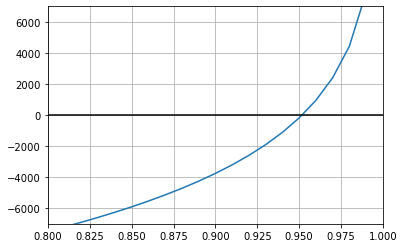

In [131]:
plt.plot(dx, Gout)
plt.xlim(0.8, 1)
plt.axhline(color='0')
plt.ylim(-7000, 7000)
plt.grid()

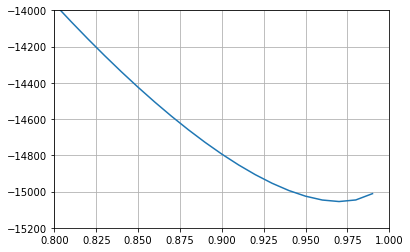

In [139]:
plt.plot(dx, Gibbs)
plt.xlim(0.8, 1)
plt.axhline(color='0')
plt.ylim(-15200, -14000)
plt.grid()

In [ ]:

def f3it(x):
    T = x[-1]
    RT = 8.3145*T
    A = np.array([[1, 0, -2], [0, 1, -1], [2*x[0], x[1], 0]])
    
    b = np.array([-np.log(x[0]/V), -np.log(x[1]/V)-3000/RT, 2-x[0]*2-x[1]])
    
    return linalg.solve(A, b)